<a href="https://colab.research.google.com/github/paultgriffiths/CCIR-RR/blob/main/weighted_air_temps_using_xarray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture

! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis netCDF4

#PG for making maps
# a fix from https://github.com/SciTools/cartopy/issues/1893
# because of a mismatch between Ubuntu vn and Cartopy required LIBGEOS :(
!pip install -q condacolab

# then run the code to install new cartopy
import condacolab
condacolab.install()
!mamba install -q -c conda-forge cartopy

In [6]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

In [5]:
# use this if file stored on Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
personal_dir = 'CCIR-2023'
if os.path.isfile("/content/drive/MyDrive/"+personal_dir+"/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc")==False:
    !wget https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc
    !mv /content/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc  /content/drive/MyDrive/CCIR-2023/CCIR-TK/
else:
    print("we have our HadCRUT5 data!")

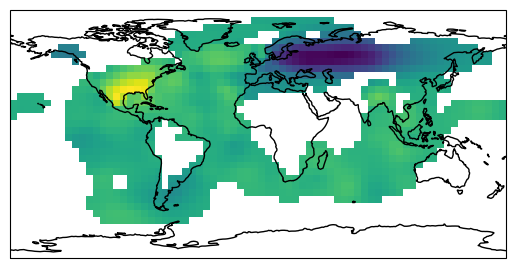

In [8]:
hadcrut5 = xr.open_dataset('/content/drive/MyDrive/CCIR-2023/CCIR-TK/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc')
# sanity check
hadcrut5.variables['tas_mean'][0,:,0]

# plot some data on a Map
lon = hadcrut5.variables['longitude'][:]
lat = hadcrut5.variables['latitude'][:]
data_to_plot = hadcrut5.variables['tas_mean'][0,:,:]

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
plt.pcolormesh(lon, lat, data_to_plot, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

In [9]:
# assuming we don't already have this one!
!wget https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/diagnostics/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.nc
hadcrut5nc = xr.open_dataset('/content/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.nc')


--2023-07-27 00:52:38--  https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/diagnostics/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.nc
Resolving www.metoffice.gov.uk (www.metoffice.gov.uk)... 184.27.151.235
Connecting to www.metoffice.gov.uk (www.metoffice.gov.uk)|184.27.151.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34756 (34K) [application/x-netcdf]
Saving to: ‘HadCRUT.5.0.1.0.analysis.summary_series.global.annual.nc’

HadCRUT.5.0.1.0.ana 100%[===================>]  33.94K  --.-KB/s    in 0.03s   

2023-07-27 00:52:39 (1.03 MB/s) - ‘HadCRUT.5.0.1.0.analysis.summary_series.global.annual.nc’ saved [34756/34756]



In [10]:
cesm2_tas = xr.open_dataset('/content/drive/MyDrive/CCIR-2023/CCIR-TK/tas_Amon_CESM2-WACCM_historical_r2i1p1f1_gn_185001-201412.nc')

/usr/local/lib/python3.10/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [11]:
cesm2_tas.time # can see it's CFTime, not datetime64...

<xarray.DataArray 'time' (time: 1980)>
array([cftime.DatetimeNoLeap(1850, 1, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 14, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 15, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2014, 10, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 15, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
    title:          time
    type:           double

In [12]:
# lifted verbatim from https://docs.xarray.dev/en/stable/examples/area_weighted_temperature.html
weights = np.cos(np.deg2rad(cesm2_tas.lat))
weights.name = "weights"

In [13]:
cesm2_tas_weighted = cesm2_tas.tas.weighted(weights) # https://docs.xarray.dev/en/stable/generated/xarray.DataArray.weighted.html
cesm2_tas_weighted_mean = cesm2_tas_weighted.mean(dim=("lon", "lat"))
cesm2_tas_unweighted_mean = cesm2_tas.tas.mean(dim=("lon","lat"))

Text(0.5, 0.98, 'Weighted vs unweighted global mean surface temperature in CESM2-WACCM')

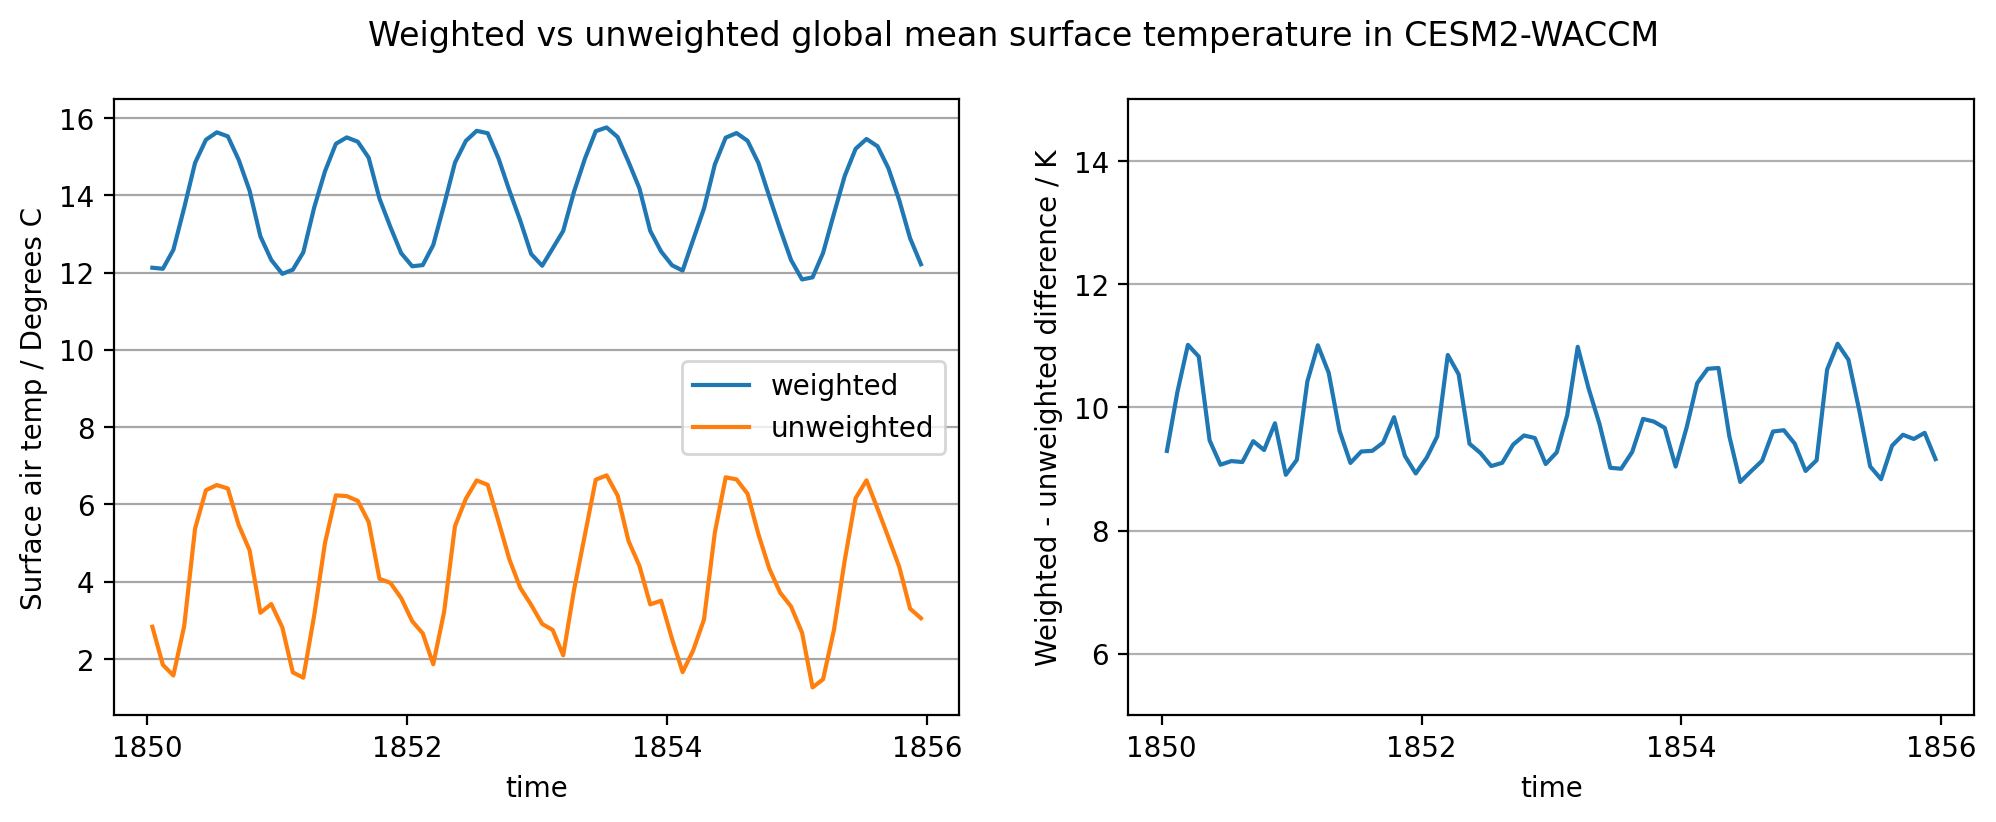

In [14]:
plt.figure(figsize=(12,4), dpi=200.)
plt.subplot(1,2,1)
(cesm2_tas_weighted_mean.sel(time=slice('1850-01-01','1856-01-01'))-273.15).plot(label="weighted")
(cesm2_tas_unweighted_mean.sel(time=slice('1850-01-01','1856-01-01'))-273.15).plot(label="unweighted")
plt.legend()
plt.ylabel('Surface air temp / Degrees C')
plt.grid(axis='y', which='major', color='gray', alpha=0.7)

plt.subplot(1,2,2)
( cesm2_tas_weighted_mean.sel(time=slice('1850-01-01','1856-01-01')) -
  cesm2_tas_unweighted_mean.sel(time=slice('1850-01-01','1856-01-01'))
  ).plot(label='difference')
plt.ylim(5,15)
plt.ylabel('Weighted - unweighted difference / K')
plt.grid(axis='y', which='major')
plt.suptitle('Weighted vs unweighted global mean surface temperature in CESM2-WACCM')

In [ ]:
# https://xarray.pydata.org/en/v0.11.3/time-series.html is waiting for us